In [1]:
import pandas as pd
import numpy as np
import javalang
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.metrics import edit_distance
import subprocess
import tempfile
from tqdm import tqdm

In [2]:
m0_data = pd.read_csv("ss21_processed_solutions/m0_data.csv")
m0_file_data = pd.read_csv("ss21_processed_solutions/m0_file_data.csv")

In [3]:
# create a formatted version of the code, adhering to Google's Java format
def format_java_code(java_code):
    temp_file = tempfile.NamedTemporaryFile(suffix=".java", delete=False)
    temp_file.write(java_code.encode())  
    temp_file.close()
    command = ["java", "-jar", "google-java-format.jar", "--replace", temp_file.name]
    result = subprocess.run(command, capture_output=True, text=True)
    with open(temp_file.name, "r", encoding="utf8") as file:
        formatted_code = file.read()
    return formatted_code

Feature engineering directly from the code and from the AST tree representation of the code via javalang:

In [4]:
def extract_features(data, file_data):
    formatted_data = file_data.iloc[:, :7].copy()
    data = data.copy()
    file_data = file_data.copy()
    
    data["num_chars"] = data["code"].str.len()
    data["num_lines"] = data["code"].apply(lambda row: len(row.splitlines()))
    data["avg_line_length"] = data["code"].apply(lambda row: np.mean([len(line) for line in row.splitlines() if len(line)>0]))
    data["max_line_length"] = data["code"].apply(lambda row: max([len(line) for line in row.splitlines() if len(line)>0]))
    data["num_scaled_comments"] = (data["code"].str.count("//") + data["code"].str.count("/\*")) / data["num_lines"]
    data["num_scaled_if"] = data["code"].str.count("if") / data["num_lines"]
    data["num_scaled_for"] = data["code"].str.count("for") / data["num_lines"]
    data["num_scaled_switch"] = data["code"].str.count("switch") / data["num_lines"]
    data["num_scaled_digits"] = (data["code"].apply(lambda row: len([value for value in row if value.isdigit()]))) / data["num_lines"]
    data["num_scaled_exceptions"] = data["code"].str.count("throw new") / data["num_lines"]
    data["num_scaled_empty_lines"] = data["code"].str.count("\n\n") / data["num_lines"]
    data["num_scaled_whitespace"] = data["code"].str.count(" ") / data["num_lines"]
    data["num_scaled_indents"] = (data["code"].apply(lambda row: sum([len(line) - len(line.lstrip()) for line in row.splitlines()]))) / data["num_lines"]
    data["num_scaled_prints"] = data["code"].str.count("print") / data["num_lines"]
    data["prop_spaces_around_assignments"] = (data["code"].str.count(r" =[^=<>!+-]") + data["code"].str.count(r"[^=<>!+-]= ")) /  (2 * data["code"].str.count(r"[^=<>!+-]=[^=<>!+-]"))

    file_data["num_method_declarations"] = file_data["code"].apply(lambda row: len([node.name for path, node in javalang.parse.parse(row).filter(javalang.tree.MethodDeclaration)]))
    file_data["num_declared_fields"] = file_data["code"].apply(lambda row: len([declarator.name for path, node in javalang.parse.parse(row).filter(javalang.tree.FieldDeclaration) for declarator in node.declarators]))
    file_data["num_local_variables"] = file_data["code"].apply(lambda row: len([declarator.name for path, node in javalang.parse.parse(row).filter(javalang.tree.LocalVariableDeclaration) for declarator in node.declarators]))
    file_data["num_classes"] = file_data["code"].apply(lambda row: len([node.name for path, node in javalang.parse.parse(row).filter(javalang.tree.ClassDeclaration)]))
    file_data["num_field_references"] = file_data["code"].apply(lambda row: len([node.member for path, node in javalang.parse.parse(row).filter(javalang.tree.MemberReference)]))
    file_data["num_method_invocations"] = file_data["code"].apply(lambda row: len([node.member for path, node in javalang.parse.parse(row).filter(javalang.tree.MethodInvocation)]))
    file_data["num_imports"] = file_data["code"].apply(lambda row: len([node.path for path, node in javalang.parse.parse(row).filter(javalang.tree.Import)]))
    file_data["used_field_types"] = (file_data["code"].apply(lambda row: [node.type.name for path, node in javalang.parse.parse(row).filter(javalang.tree.FieldDeclaration)]) 
                                     + file_data["code"].apply(lambda row: [node.type.name for path, node in javalang.parse.parse(row).filter(javalang.tree.LocalVariableDeclaration)])).apply(set)
    for data_type in ["boolean", "List", "Integer", "Point", "ArrayList", "StringBuilder"]:
        file_data[f"used_{data_type}"] = file_data["used_field_types"].apply(lambda row: data_type in row)
    file_data["variable_names"] = file_data["code"].apply(lambda row: list({node.member for path, node in javalang.parse.parse(row).filter(javalang.tree.MemberReference)}))
    
    variable_names = file_data.groupby(["name", "source", "style", "version"], dropna=False)["variable_names"].sum().reset_index()
    variable_names["avg_name_length"] = variable_names["variable_names"].apply(lambda row: np.mean([len(value) for value in row]))
    variable_names["max_name_length"] = variable_names["variable_names"].apply(lambda row: np.max([len(value) for value in row]))
    variable_names.drop("variable_names", axis=1, inplace=True)
    file_data.drop("variable_names", axis=1, inplace=True)
    file_data["all_comments"] = file_data["code"].apply(lambda row: [comment for comment in [line.strip() for comment in re.findall('/\*.*?\*/', row, re.DOTALL) for line in comment.splitlines()] if comment != "/*" and comment != "*/"]\
                                                      + [comment[2:].strip() for comment in re.findall('//.*', row)])
    variable_names = variable_names.merge(file_data.groupby(["name", "source", "style", "version"], dropna=False)["all_comments"].sum().reset_index(), on = ["name", "source", "style", "version"])
    variable_names["avg_comment_length"] = variable_names["all_comments"].apply(lambda row: 0 if len(row) == 0 else np.mean([len(value) for value in row]))
    variable_names["max_comment_length"] = variable_names["all_comments"].apply(lambda row: 0 if len(row) == 0 else np.max([len(value) for value in row]))
    variable_names.drop("all_comments", axis=1, inplace=True)
    file_data.drop("all_comments", axis=1, inplace=True)

    file_data["num_files"] = 1

    grouped_file_data = file_data.groupby(["name", "source", "style", "version"], dropna=False).sum().reset_index()
    for data_type in ["boolean", "List", "Integer", "Point", "ArrayList", "StringBuilder"]:
        grouped_file_data[f"used_{data_type}"] = grouped_file_data[f"used_{data_type}"].astype(bool)
    
    grouped_file_data = grouped_file_data.merge(data[["name", "source", "style", "version", "num_lines"]], on=["name", "source", "style", "version"])
    grouped_file_data_columns = [column for column in grouped_file_data.columns if column[:3]=="num" and column != "num_files"]

    for column in grouped_file_data_columns:
        grouped_file_data[f"num_scaled_{column[4:]}"] = grouped_file_data[column] / grouped_file_data["num_lines"]
        grouped_file_data.drop(column, axis=1, inplace=True)

    data = data.merge(grouped_file_data.drop("num_scaled_lines", axis=1), on=["name", "source", "style", "version"])
    data = data.merge(variable_names, on=["name", "source", "style", "version"])

    formatted_code = [format_java_code(code) for code in list(formatted_data["code"])]
    edit_distances = [edit_distance(format_code, original_code) for format_code, original_code in tqdm(zip(formatted_code, list(formatted_data["code"])), total=len(formatted_code))]
    formatted_data["edit_distances"] = edit_distances
    formatted_data["formatted_code"] = formatted_code
    
    data["formatted_code"] = list(formatted_data.groupby(["source", "name", "style", "version"], dropna=False)["formatted_code"].apply(lambda row:"\n".join(row)))
    data["edit_distance"] = list(formatted_data.groupby(["source", "name", "style", "version"], dropna=False)["edit_distances"].sum()) 
    data["scaled_edit_distance"] = data["edit_distance"] / data["num_lines"]
    data.drop("edit_distance", axis=1, inplace=True)
    data["diff_num_chars"] = data["num_chars"] - data["formatted_code"].str.len()
    data["diff_num_lines"] = data["formatted_code"].apply(lambda row: len(row.splitlines())) - data["num_lines"]
    data["diff_avg_line_length"] = data["avg_line_length"] - data["formatted_code"].apply(lambda row: np.mean([len(line) for line in row.splitlines() if len(line)>0]))
    data["diff_max_line_length"] = data["max_line_length"] - data["formatted_code"].apply(lambda row: max([len(line) for line in row.splitlines() if len(line)>0]))
    data["diff_num_scaled_empty_lines"] = (data["formatted_code"].str.count("\n\n") - data["code"].str.count("\n\n")) / data["num_lines"]
    data["diff_num_scaled_whitespace"] = (data["code"].str.count(" ") - data["formatted_code"].str.count(" ")) / data["num_lines"]
    data["diff_num_scaled_indents"] = ((data["code"].apply(lambda row: sum([len(line) - len(line.lstrip()) for line in row.splitlines()]))) - (data["formatted_code"].apply(lambda row: sum([len(line) - len(line.lstrip()) for line in row.splitlines()])))) / data["num_lines"]
    data.drop("formatted_code", axis=1, inplace=True)
    
    return data

In [31]:
m0_features = extract_features(m0_data, m0_file_data)

100%|██████████████████████████████████████████████████████████████████████████████| 501/501 [1:07:54<00:00,  8.13s/it]


In [32]:
m0_features.to_csv("ss21_processed_solutions/m0_feature_data.csv", index=False)

If the features are not scaled, then they simply reflect the length of the code - e.g. longer code naturally has more field references, etc.  
By dividing each feature by the length of the code, we can extract whether a relatively large or small number of e.g. field references have been included.

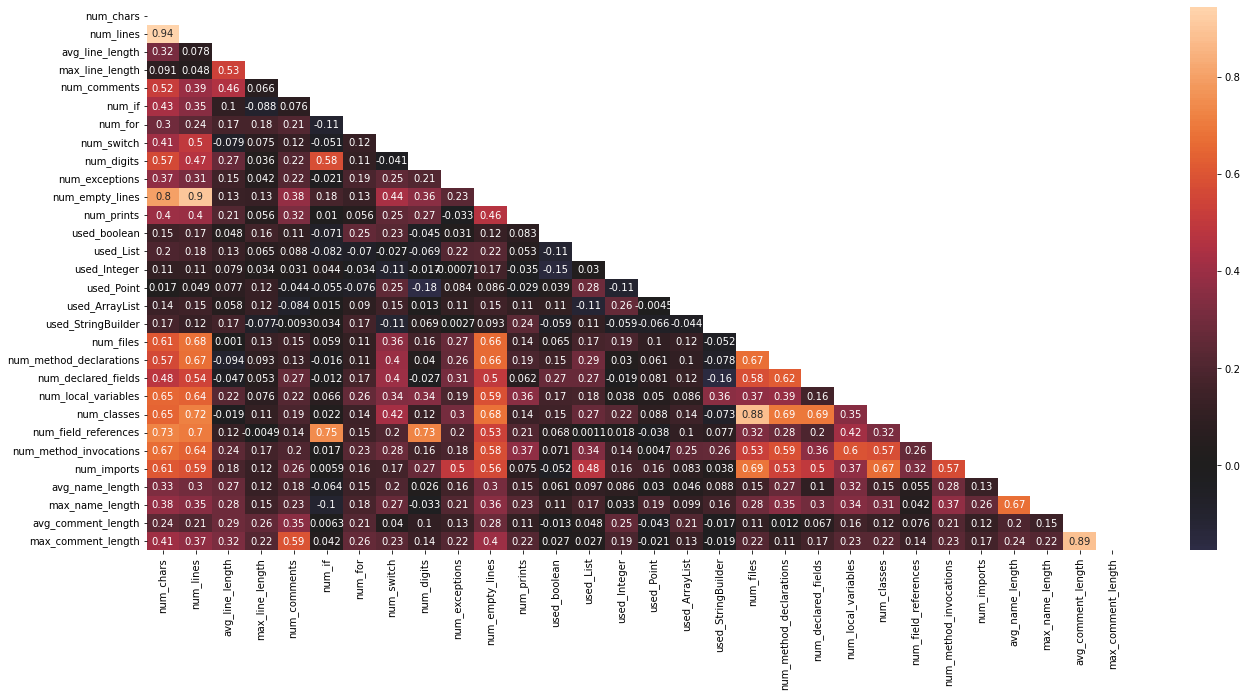

In [24]:
non_scaled_data = m0_features.copy()
scaled_columns = [column for column in m0_features.columns if "scaled" in column]
for column in scaled_columns:
    non_scaled_data[column] = non_scaled_data[column] * non_scaled_data["num_lines"]

non_scaled_data.columns = list(pd.Series(non_scaled_data.columns).str.replace("_scaled", ""))
plt.subplots(figsize=(22, 10))
sns.heatmap(non_scaled_data.corr(), center=0, annot=True, mask=np.triu(np.ones_like(m0_features.corr(), dtype=bool)));

## Process additional optimised solutions

In [5]:
optimised_data = pd.read_csv("ss21_processed_solutions/optimised_data.csv")
optimised_file_data = pd.read_csv("ss21_processed_solutions/optimised_file_data.csv")

In [6]:
optimised_features = extract_features(optimised_data, optimised_file_data)
optimised_features.to_csv("ss21_processed_solutions/optimised_feature_data.csv", index=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [05:46<00:00,  4.62s/it]
